# Imports

In [59]:
import os
import math
import pandas as pd
import time
from pathlib import Path
import matplotlib.pyplot as plt

import numpy as np
from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_class_weight
from torch.utils.data import DataLoader, WeightedRandomSampler

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from tqdm import tqdm

# Data Analysis and preprocessing

In [15]:
df_message_AAPL = pd.read_csv("Data/LOBSTER_SampleFile_AAPL_2012-06-21_50/AAPL_2012-06-21_34200000_37800000_message_50.csv")
df_message_AAPL.head()

,34200.004241176,1,16113575,18,5853300,1.1
0,34200.004261,1,16113584,18,5853200,1
1,34200.004447,1,16113594,18,5853100,1
2,34200.025552,1,16120456,18,5859100,-1
3,34200.025580,1,16120480,18,5859200,-1
4,34200.025613,1,16120503,18,5859300,-1


In [16]:
df_AAPL_OB  = pd.read_csv("Data/LOBSTER_SampleFile_AAPL_2012-06-21_50/AAPL_2012-06-21_34200000_37800000_orderbook_50.csv")
df_AAPL_OB.head()

,5859400,200,5853300,18,5859800,200.1,5853000,150,5861000,200.2,...,4689600,200.4,9999999999.8,0.8,4689500,1900,9999999999.9,0.9,4689400,400.3
0,5859400,200,5853300,18,5859800,200,5853200,18,5861000,200,...,4736500,100,9999999999,0,4689600,200,9999999999,0,4689500,1900
1,5859400,200,5853300,18,5859800,200,5853200,18,5861000,200,...,4785900,100,9999999999,0,4736500,100,9999999999,0,4689600,200
2,5859100,18,5853300,18,5859400,200,5853200,18,5859800,200,...,4785900,100,9999999999,0,4736500,100,9999999999,0,4689600,200
3,5859100,18,5853300,18,5859200,18,5853200,18,5859400,200,...,4785900,100,9999999999,0,4736500,100,9999999999,0,4689600,200
4,5859100,18,5853300,18,5859200,18,5853200,18,5859300,18,...,4785900,100,9999999999,0,4736500,100,9999999999,0,4689600,200


In [17]:
# Renommer les colonnes de df_messages selon la spécification
rename_mapping = {
    df_message_AAPL.columns[0]: "Time",        # Seconds after midnight (float, ms à ns)
    df_message_AAPL.columns[1]: "Type",        # Type d'événement (1,2,3,4,5,7)
    df_message_AAPL.columns[2]: "OrderID",     # Identifiant unique de l'ordre
    df_message_AAPL.columns[3]: "Size",        # Nombre d'actions
    df_message_AAPL.columns[4]: "Price",       # Prix * 10 000
    df_message_AAPL.columns[5]: "Direction"    # -1: Sell, 1: Buy
}

df_message_AAPL = df_message_AAPL.rename(columns=rename_mapping)

# Vérification
print(df_message_AAPL.head())
print("\nColonnes renommées :", df_message_AAPL.columns.tolist())

           Time  Type   OrderID  Size    Price  Direction
0  34200.004261     1  16113584    18  5853200          1
1  34200.004447     1  16113594    18  5853100          1
2  34200.025552     1  16120456    18  5859100         -1
3  34200.025580     1  16120480    18  5859200         -1
4  34200.025613     1  16120503    18  5859300         -1

Colonnes renommées : ['Time', 'Type', 'OrderID', 'Size', 'Price', 'Direction']


<Axes: >

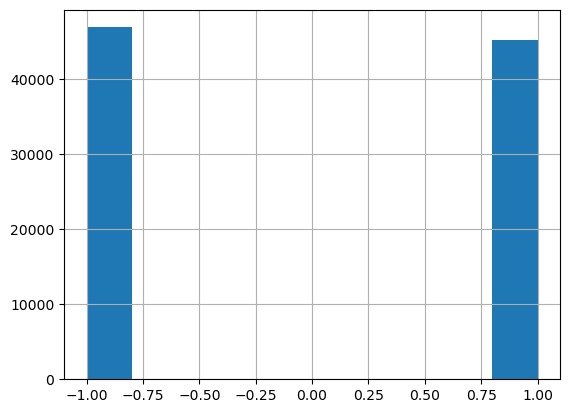

In [18]:
df_message_AAPL['Direction'].hist()

In [19]:
num_levels = 10  

new_columns = []
for level in range(1, num_levels + 1):
    new_columns += [
        f"AskPrice_{level}", 
        f"AskSize_{level}",
        f"BidPrice_{level}",
        f"BidSize_{level}",
    ]

if len(df_AAPL_OB.columns) < len(new_columns):
    raise ValueError(
        f"Le DataFrame contient seulement {len(df_AAPL_OB.columns)} colonnes, "
        f"mais {len(new_columns)} sont requises pour {num_levels} niveaux."
    )

df_AAPL_OB = df_AAPL_OB.iloc[:, :len(new_columns)]

df_AAPL_OB.columns = new_columns

print(df_AAPL_OB.columns[:8])  
print(f"\nTotal colonnes renommées : {len(df_AAPL_OB.columns)}")

Index(['AskPrice_1', 'AskSize_1', 'BidPrice_1', 'BidSize_1', 'AskPrice_2',
       'AskSize_2', 'BidPrice_2', 'BidSize_2'],
      dtype='object')

Total colonnes renommées : 40


In [20]:
scaler = StandardScaler()

df_AAPL_OB_scaled = pd.DataFrame(
    scaler.fit_transform(df_AAPL_OB),
    columns=df_AAPL_OB.columns,
    index=df_AAPL_OB.index
)

print(df_AAPL_OB_scaled.describe().loc[["mean", "std"]])

        AskPrice_1     AskSize_1    BidPrice_1     BidSize_1    AskPrice_2  \
mean  6.648250e-14  1.977248e-17 -6.715971e-14  8.650462e-18  3.193998e-14   
std   1.000005e+00  1.000005e+00  1.000005e+00  1.000005e+00  1.000005e+00   

         AskSize_2    BidPrice_2     BidSize_2    AskPrice_3     AskSize_3  \
mean  2.965873e-17  3.224892e-14 -3.707341e-17 -5.356366e-14 -1.977248e-17   
std   1.000005e+00  1.000005e+00  1.000005e+00  1.000005e+00  1.000005e+00   

      ...    BidPrice_8     BidSize_8    AskPrice_9     AskSize_9  \
mean  ... -2.846867e-14  3.707341e-18  4.988598e-14  3.089451e-17   
std   ...  1.000005e+00  1.000005e+00  1.000005e+00  1.000005e+00   

        BidPrice_9     BidSize_9   AskPrice_10    AskSize_10   BidPrice_10  \
mean -2.429544e-14  7.414681e-18  4.539762e-14  3.521974e-17 -1.671393e-15   
std   1.000005e+00  1.000005e+00  1.000005e+00  1.000005e+00  1.000005e+00   

        BidSize_10  
mean  2.780506e-17  
std   1.000005e+00  

[2 rows x 40 columns]


In [21]:
train_size = int(0.8 * len(df_AAPL_OB))
train_df = df_AAPL_OB.iloc[:train_size]
val_df   = df_AAPL_OB.iloc[train_size:]

scaler = StandardScaler().fit(train_df)

df_AAPL_OB_train_scaled = pd.DataFrame(scaler.transform(train_df), columns=df_AAPL_OB.columns)
df_AAPL_OB_val_scaled   = pd.DataFrame(scaler.transform(val_df),   columns=df_AAPL_OB.columns)

In [22]:
df_AAPL_OB_scaled = pd.concat([df_AAPL_OB_train_scaled, df_AAPL_OB_val_scaled], axis=0)

os.makedirs("Data", exist_ok=True)
df_message_AAPL.to_csv("Data/AAPL_message.csv", index=False)
df_AAPL_OB_scaled.to_csv("Data/AAPL_OB.csv", index=False)

print("[INFO] Fichiers exportés vers Data/AAPL_message.csv et Data/AAPL_OB.csv")

[INFO] Fichiers exportés vers Data/AAPL_message.csv et Data/AAPL_OB.csv


In [43]:
def plot_label_distribution(y):
    """Affiche la distribution des classes de labels."""
    unique, counts = np.unique(y, return_counts=True)
    labels = ["Down (0)", "Flat (1)", "Up (2)"]

    plt.figure(figsize=(6, 4))
    plt.bar(labels, counts, color=["red", "gray", "green"])
    plt.title("Distribution des labels (mouvements de mid-price)")
    plt.ylabel("Nombre d'occurrences")
    plt.show()

In [44]:
def plot_midprice_with_labels(mid_prices, y, label_horizon=10, sample_len=2000):
    """
    Affiche le mid-price et les zones où le label est up/down/flat.
    - mid_prices : np.array des mid-prices
    - y : np.array des labels
    - label_horizon : horizon en ticks (pour aligner)
    - sample_len : nombre de points à tracer
    """
    plt.figure(figsize=(12, 5))
    x = np.arange(sample_len)
    plt.plot(x, mid_prices[:sample_len], color="black", linewidth=1, label="Mid-price")

    for i in range(sample_len - label_horizon):
        if y[i] == 2:
            plt.axvspan(i, i+1, color="green", alpha=0.3)
        elif y[i] == 0:
            plt.axvspan(i, i+1, color="red", alpha=0.3)
        else:
            plt.axvspan(i, i+1, color="gray", alpha=0.2)

    plt.title(f"Mid-price avec coloration des labels (horizon={label_horizon} ticks)")
    plt.xlabel("Ticks")
    plt.ylabel("Mid-price")
    plt.legend()
    plt.show()

In [45]:
def plot_example_snapshot(X, idx=0):
    """
    Affiche la matrice d'un snapshot (fenêtre temporelle) sous forme d'image.
    Chaque ligne = un tick ; chaque colonne = une feature (Ask/Bid Price/Size).
    """
    plt.figure(figsize=(10, 5))
    plt.imshow(X[idx], aspect="auto", cmap="viridis")
    plt.colorbar(label="Valeur normalisée")
    plt.title(f"Snapshot #{idx} (fenêtre LOB)")
    plt.xlabel("Features (Ask/Bid Price/Size)")
    plt.ylabel("Ticks dans la fenêtre")
    plt.show()

In [57]:
def preprocess_lobster(message_path: str,
    orderbook_path: str,
    window_size: int = 100,
    levels: int = 50,
    label_horizon: int = 10,
    smoothing_k: int = 5,
    neutral_threshold: float = 0.0001,
    out_dir: str = "Data"):
    """
    Prétraite les fichiers LOBSTER-like en snapshots numpy pour DeepLOB,
    avec lissage du mid-price et agrégation de nouvelles features :
    volume imbalance, spreads, mid-price movement.
    """

    print(f"[INFO] Chargement des fichiers : {message_path}, {orderbook_path}")
    df_message = pd.read_csv(message_path)
    df_OB = pd.read_csv(orderbook_path)

    # Vérif colonnes attendues
    assert "Time" in df_message.columns, "df_message doit contenir la colonne 'Time'"
    assert "AskPrice_1" in df_OB.columns, "df_OB doit contenir 'AskPrice_1'"

    # Nettoyage
    df_OB = df_OB.replace(-9999999999, np.nan).ffill()

    # Conversion des prix
    for col in df_OB.columns:
        if "Price" in col:
            df_OB[col] = df_OB[col] / 10000.0

    # ========================
    # Mid-price + Lissage
    # ========================
    mid_prices = (df_OB["AskPrice_1"].values + df_OB["BidPrice_1"].values) / 2
    m_minus = pd.Series(mid_prices).rolling(window=smoothing_k, min_periods=1).mean().values
    m_plus = pd.Series(mid_prices[::-1]).rolling(window=smoothing_k, min_periods=1).mean().values[::-1]
    m_plus_shifted = np.roll(m_plus, -label_horizon)
    valid_range = len(mid_prices) - label_horizon
    r = (m_plus_shifted[:valid_range] - m_minus[:valid_range]) / m_minus[:valid_range]

    # ========================
    # Labels : {-1, 0, +1}
    # ========================
    y = np.zeros_like(r, dtype=int)
    y[r > neutral_threshold] = 2   # Up
    y[r < -neutral_threshold] = 0  # Down
    y[np.abs(r) <= neutral_threshold] = 1  # Flat

    # ========================
    # Aggregated features
    # ========================
    spread_1 = df_OB["AskPrice_1"] - df_OB["BidPrice_1"]
    delta_mid = pd.Series(mid_prices).diff(smoothing_k).fillna(0).values / mid_prices

    imbalance = []
    for lvl in range(1, levels + 1):
        bid = df_OB[f"BidSize_{lvl}"].values
        ask = df_OB[f"AskSize_{lvl}"].values
        imb = (bid - ask) / (bid + ask + 1e-6)
        imbalance.append(imb)
    imbalance = np.stack(imbalance, axis=1)

    # ========================
    # Feature columns
    # ========================
    feature_cols = []
    for lvl in range(1, levels + 1):
        feature_cols += [f"AskPrice_{lvl}", f"AskSize_{lvl}", f"BidPrice_{lvl}", f"BidSize_{lvl}"]

    # Build snapshots
    X = []
    for i in tqdm(range(valid_range - window_size), desc="Création des fenêtres"):
        window_features = df_OB.loc[i:i + window_size - 1, feature_cols].values
        extra_features = np.zeros((window_size, 1 + 1 + levels))
        extra_features[:, 0] = spread_1[i:i + window_size]
        extra_features[:, 1] = delta_mid[i:i + window_size]
        extra_features[:, 2:] = imbalance[i:i + window_size]
        X.append(np.concatenate([window_features, extra_features], axis=1))
    X = np.stack(X)
    y = y[window_size:]

    print(f"[INFO] Snapshots créés avec features supplémentaires : X={X.shape}, y={y.shape}")
    # ========================
    # Sauvegarde
    # ========================
    os.makedirs(out_dir, exist_ok=True)
    np.save(os.path.join(out_dir, "snapshots.npy"), X)
    np.save(os.path.join(out_dir, "labels.npy"), y)
    print(f"[INFO] Sauvegarde : {out_dir}/snapshots.npy et labels.npy")


# Model Definition

In [76]:
# =========================================================
# 2. Dataset PyTorch
# =========================================================

class LOBDataset(Dataset):
    """Dataset PyTorch compatible DeepLOB"""
    def __init__(self, X: np.ndarray, y: np.ndarray):
        assert len(X) == len(y)
        self.X = X.astype(np.float32)
        self.y = y.astype(np.int64)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        x = self.X[idx]  # (window, features)
        y = self.y[idx]
        x = np.transpose(x, (1, 0)).copy()  # (features, window)
        return torch.from_numpy(x), torch.tensor(y)

In [77]:
# =========================================================
# 3. Modèle DeepLOB-like
# =========================================================

class InceptionBlock(nn.Module):
    def __init__(self, in_ch, out_ch, negative_slope=0.01):
        super().__init__()
        assert out_ch % 4 == 0, "out_ch must be divisible by 4"
        per = out_ch // 4

        # Use zero padding to preserve time dimension
        self.b1 = nn.Conv1d(in_ch, per, kernel_size=1, padding='same')
        self.b2 = nn.Conv1d(in_ch, per, kernel_size=3, padding='same')
        self.b3 = nn.Conv1d(in_ch, per, kernel_size=5, padding='same')
        self.b4 = nn.Sequential(
            nn.MaxPool1d(kernel_size=3, stride=1, padding=1),
            nn.Conv1d(in_ch, per, kernel_size=1, padding='same')
        )

        self.bn = nn.BatchNorm1d(out_ch)
        self.act = nn.LeakyReLU(negative_slope=negative_slope)

    def forward(self, x):
        b1 = self.act(self.b1(x))
        b2 = self.act(self.b2(x))
        b3 = self.act(self.b3(x))
        b4 = self.act(self.b4(x))
        out = torch.cat([b1, b2, b3, b4], dim=1)
        return self.bn(out)

In [78]:

class DeepLOB(nn.Module):
    def __init__(self, in_channels, n_classes=3, lstm_hidden=128, negative_slope=0.01):
        super().__init__()

        self.act = nn.LeakyReLU(negative_slope=negative_slope)

        # --- CNN layers with same padding ---
        self.conv1 = nn.Conv1d(in_channels, 64, kernel_size=3, padding='same')
        self.bn1 = nn.BatchNorm1d(64)

        # --- Inception modules (pooling is only inside them) ---
        self.inc1 = InceptionBlock(64, 128, negative_slope)
        self.inc2 = InceptionBlock(128, 128, negative_slope)

        # --- Downstream convolution before LSTM ---
        self.conv_down = nn.Conv1d(128, 64, kernel_size=3, padding='same')
        self.bn2 = nn.BatchNorm1d(64)

        # --- Bidirectional LSTM for temporal dependency ---
        self.lstm = nn.LSTM(
            input_size=64,
            hidden_size=lstm_hidden,
            batch_first=True,
            bidirectional=True
        )

        # --- Fully connected classifier ---
        self.fc = nn.Linear(lstm_hidden * 2, 64)
        self.out = nn.Linear(64, n_classes)

    def forward(self, x):
        # x shape: (batch, features, seq_len)
        x = self.act(self.bn1(self.conv1(x)))
        x = self.inc1(x)
        x = self.inc2(x)
        x = self.act(self.bn2(self.conv_down(x)))

        # Prepare for LSTM: (batch, seq_len, features)
        x = x.permute(0, 2, 1)

        out, _ = self.lstm(x)
        out = out[:, -1, :]  # last time step output

        out = self.act(self.fc(out))
        return self.out(out)

In [79]:
# =========================================================
# 4. Entraînement / Validation / Test
# =========================================================

def train_one_epoch(model, loader, optimizer, criterion, device):
    model.train()
    losses, preds, trues = [], [], []
    for X, y in loader:
        X, y = X.to(device), y.to(device)
        optimizer.zero_grad()
        logits = model(X)
        loss = criterion(logits, y)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
        preds.extend(logits.argmax(1).cpu().numpy())
        trues.extend(y.cpu().numpy())
    return np.mean(losses), accuracy_score(trues, preds)


def evaluate(model, loader, criterion, device):
    model.eval()
    losses, preds, trues = [], [], []
    with torch.no_grad():
        for X, y in loader:
            X, y = X.to(device), y.to(device)
            logits = model(X)
            loss = criterion(logits, y)
            losses.append(loss.item())
            preds.extend(logits.argmax(1).cpu().numpy())
            trues.extend(y.cpu().numpy())
    return np.mean(losses), accuracy_score(trues, preds), classification_report(trues, preds)


In [80]:
def run_training(path_snapshots, path_labels,
                 out_dir="checkpoints",
                 batch_size=128, epochs=10, lr=1e-3, n_classes=3):
    device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
    print(f"Using device : {device}")
    X = np.load(path_snapshots)
    y = np.load(path_labels)

    # Compute class weights
    class_weights = compute_class_weight('balanced', classes=np.arange(n_classes), y=y)
    class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)

    N = len(X)
    n_val = int(N * 0.15)
    n_test = int(N * 0.15)
    train_idx = np.arange(0, N - n_val - n_test)
    val_idx = np.arange(N - n_val - n_test, N - n_test)
    test_idx = np.arange(N - n_test, N)

    ds_train = LOBDataset(X[train_idx], y[train_idx])
    ds_val = LOBDataset(X[val_idx], y[val_idx])
    ds_test = LOBDataset(X[test_idx], y[test_idx])

    loader_train = DataLoader(ds_train, batch_size=batch_size, shuffle=True)
    loader_val = DataLoader(ds_val, batch_size=batch_size)
    loader_test = DataLoader(ds_test, batch_size=batch_size)

    in_ch, seq_len = ds_train[0][0].shape
    model = DeepLOB(in_channels=in_ch, n_classes=n_classes).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    # Pass class weights to the loss
    criterion = nn.CrossEntropyLoss(weight=class_weights)

    best_val = -math.inf
    os.makedirs(out_dir, exist_ok=True)

    for ep in range(1, epochs + 1):
        train_loss, train_acc = train_one_epoch(model, loader_train, optimizer, criterion, device)
        val_loss, val_acc, _ = evaluate(model, loader_val, criterion, device)
        print(f"Epoch {ep}: train {train_loss:.4f}/{train_acc:.4f} | val {val_loss:.4f}/{val_acc:.4f}")
        if val_acc > best_val:
            best_val = val_acc
            torch.save(model.state_dict(), os.path.join(out_dir, "best.pth"))

    model.load_state_dict(torch.load(os.path.join(out_dir, "best.pth"), map_location=device))
    test_loss, test_acc, report = evaluate(model, loader_test, criterion, device)
    print("=== TEST ===")
    print(report)

In [81]:
# =========================================================
# 5. Exemple d’utilisation -> should run it on colab not on local
# =========================================================

if __name__ == "__main__":
    #preprocess_lobster(
    #    message_path="Data/AAPL_message.csv",
    #    orderbook_path="Data/AAPL_OB.csv",
    #    window_size=100,
    #    levels=10,            # profondeur que tu veux garder
    #    label_horizon=10,     # horizon prédictif
    #    smoothing_k=5,        # moyenne sur k ticks avant/après
    #    out_dir="Data"
    #)

    PATH_SNAP = "Data/snapshots.npy"
    PATH_LABELS = "Data/labels.npy"
    run_training(PATH_SNAP, PATH_LABELS)

Using device : mps
Epoch 1: train 1.0905/0.4026 | val 1.1112/0.3592
Epoch 2: train 1.0887/0.3915 | val 1.1208/0.3557
Epoch 3: train 1.0861/0.3975 | val 1.1197/0.3386
Epoch 4: train 1.0874/0.3861 | val 1.1242/0.3378
Epoch 5: train 1.0893/0.3918 | val 1.1282/0.3478
Epoch 6: train 1.0862/0.3895 | val 1.1031/0.3888
Epoch 7: train 1.0833/0.3868 | val 1.1318/0.3811
Epoch 8: train 1.0770/0.3911 | val 1.1765/0.3536
Epoch 9: train 1.0748/0.3942 | val 1.1436/0.3700
Epoch 10: train 1.0698/0.3945 | val 1.1321/0.3703
=== TEST ===
              precision    recall  f1-score   support

           0       0.49      0.04      0.08      6072
           1       0.26      0.28      0.27      2351
           2       0.41      0.81      0.54      5359

    accuracy                           0.38     13782
   macro avg       0.39      0.38      0.30     13782
weighted avg       0.42      0.38      0.29     13782



# Check Metrics

In [ ]:
X = np.load("Data/snapshots.npy")   # → input features
y = np.load("Data/labels.npy")      # → target labels

N = len(X)
n_val = int(N * 0.15)
n_test = int(N * 0.15)
train_idx = np.arange(0, N - n_val - n_test)
val_idx = np.arange(N - n_val - n_test, N - n_test)
test_idx = np.arange(N - n_test, N)

ds_train = LOBDataset(X[train_idx], y[train_idx])
ds_val = LOBDataset(X[val_idx], y[val_idx])
ds_test = LOBDataset(X[test_idx], y[test_idx])

y_train = y[train_idx]

In [ ]:
(unique, counts) = np.unique(y_train, return_counts=True)
print("Class distribution in training set:", dict(zip(unique, counts)))

Class distribution in training set: {0: 27194, 1: 9667, 2: 27461}


In [ ]:
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)

criterion = nn.CrossEntropyLoss(weight=class_weights)

In [ ]:
print(class_weights)

tensor([0.7884, 2.2179, 0.7808], device='mps:0')
